# Cluster strategy

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
pio.templates.default = "simple_white"


# Set seeds for reproducibility
seed = 123


# Read data
df = pd.read_csv(
    r'C:\Users\Eric\Documents\employee-attrition\employee-attrition\data\employee_churn_data.csv')

# Separate labels and target
X, y =  df.drop(columns="left", axis = 1), df["left"]

# Get variable names
bi_vars = [col for col in X.columns if X[col].nunique() == 2]
num_vars = [col for col in X.columns if (X[col].dtype in ["int8", "float32"]) & (col not in bi_vars)]
cat_vars = [col for col in X.columns if (col not in num_vars) & (col not in bi_vars)]

# Encode
#df.left = df.left.map({1:"Yes",0:"No"})
#df.bonus = df.bonus.map({1:"Yes",0:"No"})
#df.promoted = df.promoted.map({1:"Yes",0:"No"})


In [3]:
# Copy training datafrane for clusters
df_cluster = df.copy()

### Select cluster variables

In [4]:
# Creating dataframe with relevant features for the employee segmentation 
cluster_features = ['review', 'satisfaction', 'avg_hrs_month']
left_cluster = df[cluster_features]
left_cluster.head()

,review,satisfaction,avg_hrs_month
0,0.577569,0.626759,180.866070
1,0.751900,0.443679,182.708149
2,0.722548,0.446823,184.416084
3,0.675158,0.440139,188.707545
4,0.676203,0.577607,179.821083


In [5]:
# Checking correlations
left_cluster.corr()

,review,satisfaction,avg_hrs_month
review,1.000000,-0.349778,-0.196096
satisfaction,-0.349778,1.000000,-0.143142
avg_hrs_month,-0.196096,-0.143142,1.000000


In [6]:
# Normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(left_cluster)
scaled_left_cluster = scaler.transform(left_cluster)
scaled_left_cluster

array([[0.38778067, 0.62675897, 0.32189838],
       [0.64043429, 0.44367895, 0.38436801],
       [0.5978963 , 0.44682322, 0.44228847],
       ...,
       [0.3593908 , 0.70542476, 0.51401098],
       [0.39774745, 0.60728698, 0.55166619],
       [0.45851201, 0.70645479, 0.4933218 ]])

### Selecting  K

In [7]:
from sklearn.cluster import KMeans
# Choosing optimal number of clusters through sum of squared errors plot
sse = []
n_clusters = 20

for k in range(1, n_clusters + 1):
    km = KMeans(n_clusters=k, random_state=1234).fit(scaled_left_cluster)
    sse.append(km.inertia_) 
    
#creating a dataframe for the sum of squared error results
df_sse = pd.DataFrame({'Number of Clusters': range(1, n_clusters + 1), 'Sum of Squared Error': sse})

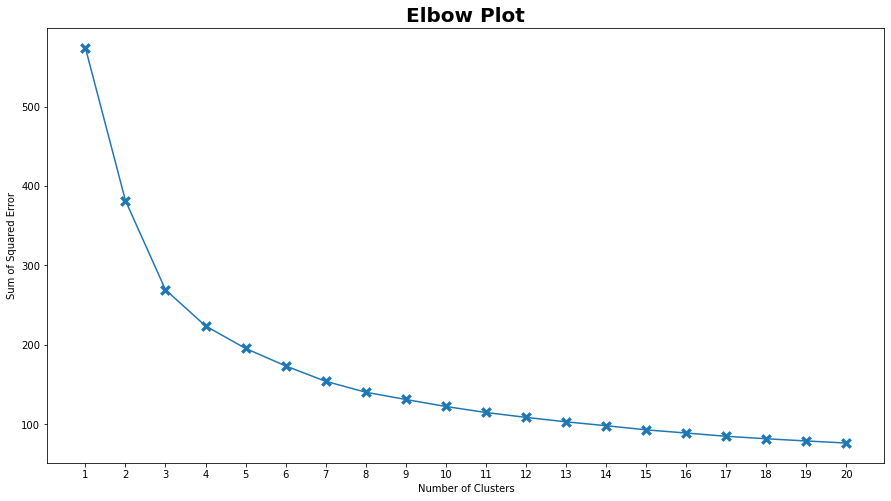

Total error: 76.33

Best candidates for number of clusters: 2, 3, 4 and 5;


In [8]:
import seaborn as sns
#plotting sum of squared error results
plt.figure(figsize = (15, 8))
sns.lineplot(data = df_sse, x = 'Number of Clusters', y = 'Sum of Squared Error')
sns.scatterplot(data = df_sse, x = 'Number of Clusters', y = 'Sum of Squared Error', marker = 'X', s = 150)

#customizing
plt.xticks(range(1, n_clusters +1, 1))
plt.title('Elbow Plot', fontweight = 'bold', fontsize=20)

plt.show() 

print(f'Total error: {round(km.inertia_,2)}\n\nBest candidates for number of clusters: 2, 3, 4 and 5;')

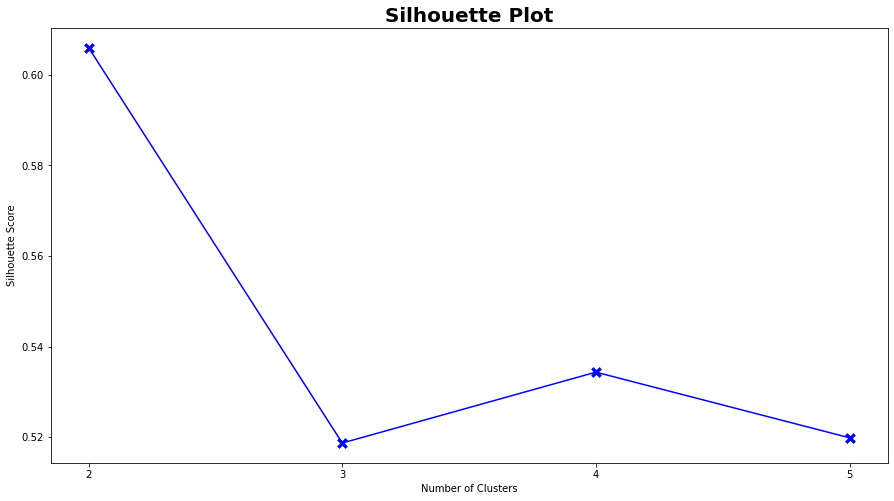

For n_clusters = 2 The average silhouette score is : 0.61
For n_clusters = 3 The average silhouette score is : 0.52
For n_clusters = 4 The average silhouette score is : 0.53
For n_clusters = 5 The average silhouette score is : 0.52


In [9]:
from sklearn.metrics import silhouette_score
# Benchmarking clusters by measuring the degree of separation between candidates for k through silhouette score 
candidates = [2,3,4,5] 
sc = [] 

for n_clusters in candidates:
    km = KMeans(n_clusters=n_clusters, random_state=seed)
    km_labels = km.fit_predict(left_cluster)
    score = silhouette_score(left_cluster, km_labels)
    sc.append(score) 
    
# creating a dataframe for the sum of silhouette score
df_sc = pd.DataFrame({'Number of Clusters': range(2, 6), 'Silhouette Score': sc})

# plotting sum of squared error results
plt.figure(figsize = (15, 8))
sns.lineplot(data = df_sc, x = 'Number of Clusters', y = 'Silhouette Score', color='blue')
sns.scatterplot(data = df_sc, x = 'Number of Clusters', y = 'Silhouette Score', marker = 'X', s = 150,color='blue')

# customizing
plt.xticks([2,3,4,5])
plt.title('Silhouette Plot', fontweight='bold', fontsize=20)

plt.show()  

# answer
for n_clusters in candidates:  
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(left_cluster)
    score = silhouette_score(left_cluster, km_labels)
    print('For n_clusters =', n_clusters,'The average silhouette score is :',round(score,2))

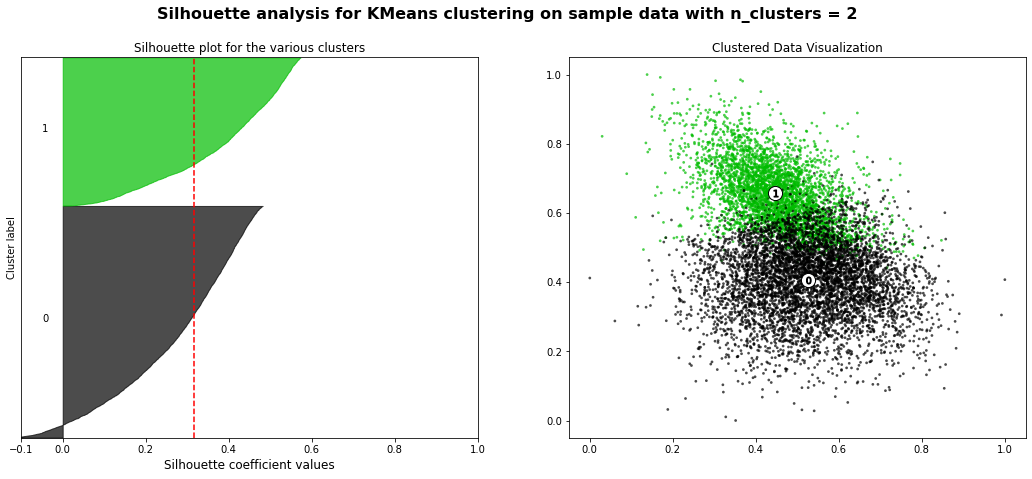

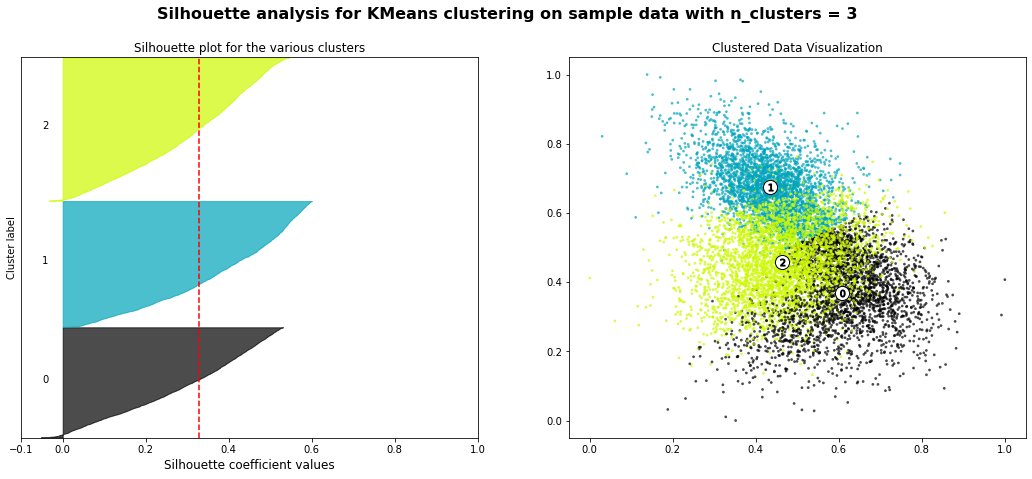

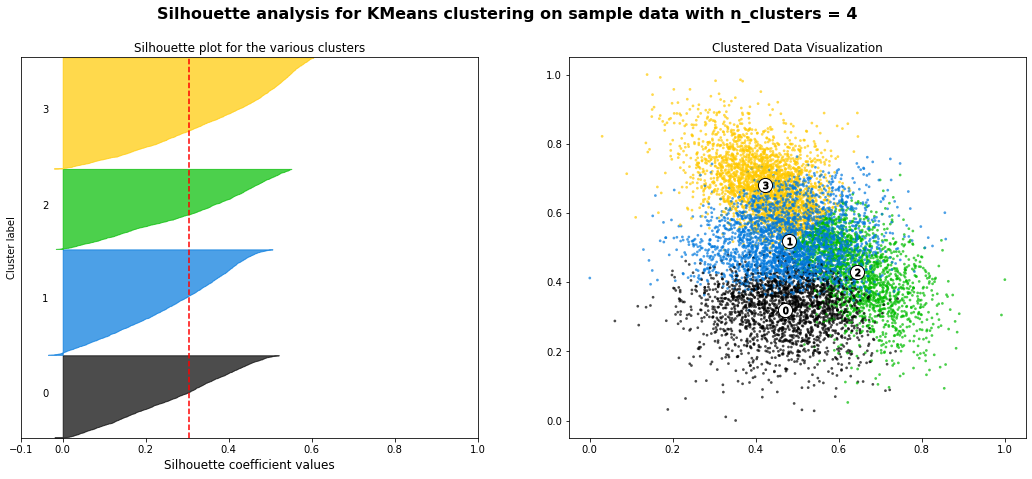

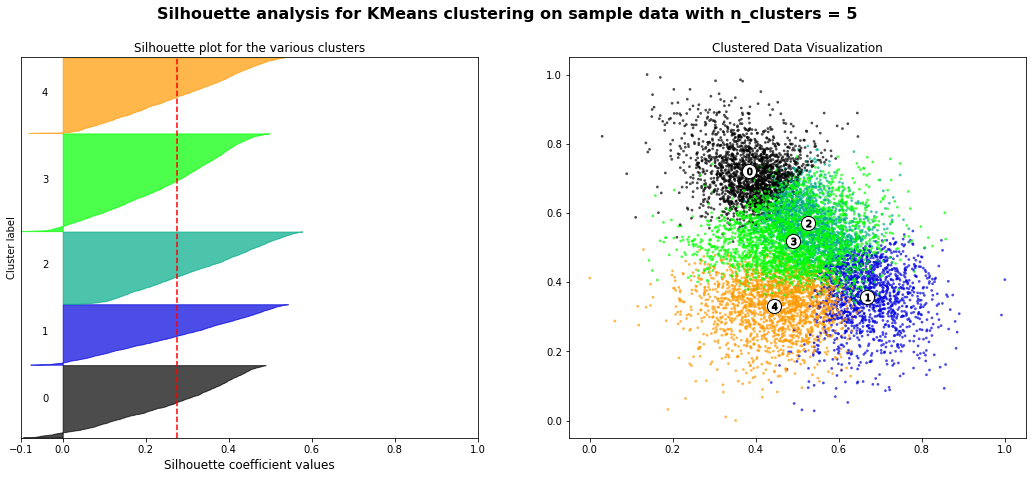

In [10]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
# Checking candidates cluster separation and density visually

for n_clusters in candidates:
    # Creating a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot 
    # The silhouette coefficient can range from [-1, 1]
    ax1.set_xlim([-0.1, 1])
    # (n_clusters+1)*10 is used for the insertion of a blank space between silhouetteplots to demarcate them
    ax1.set_ylim([0, len(scaled_left_cluster) + (n_clusters + 1) * 10])
    
    # Initializing the km with n_clusters value and a random generator seed of 10 for reproducibility
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(scaled_left_cluster)
    silhouette_avg = silhouette_score(scaled_left_cluster, km_labels)
    
    # Computing the silhouette scores for each sample
    sample_values = silhouette_samples(scaled_left_cluster, km_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregating the silhouette scores for samples belonging to cluster i and sorting them
        ith_cluster_values = sample_values[km_labels == i]
        ith_cluster_values.sort()
        size_cluster_i = ith_cluster_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Labeling the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Computing the new y_lower for next plot (10 for the 0 samples)
        y_lower = y_upper + 10
    
    ax1.set_title('Silhouette plot for the various clusters', fontsize=12)
    ax1.set_xlabel('Silhouette coefficient values', fontsize=12)
    ax1.set_ylabel('Cluster label')

    # Setting the vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    
    # Clearing the y axis ticks and setting the x axis ticks on a range from [-1,1] with 0.2 sep
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(km_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_left_cluster[:, 0], scaled_left_cluster[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
    )
    # Labeling the clusters
    centers = km.cluster_centers_
    
    # Drawing white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker='o',
        c='white',
        alpha=1,
        s=200,
        edgecolor='k',
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title('Clustered Data Visualization')
    ax2.set_xlabel('')
    ax2.set_ylabel('')

    plt.suptitle(
        'Silhouette analysis for KMeans clustering on sample data with n_clusters = %d'
        % n_clusters,
        fontsize=16,
        fontweight='bold',
    ) 
    plt.plot() 

### Profiling clusters

In [23]:
# Adding the cluster labels as a new feature called turnover_segmentation in my clustered dataset
k = 3
km = KMeans(n_clusters=k, random_state=seed).fit(scaled_left_cluster) 
labels = km.labels_
df_cluster['left_segmentation'] = labels

# Checking turnover segmentation features according to centroids 
centroids = df_cluster.groupby('left_segmentation')[cluster_features].mean().round(2)
centroids

,review,satisfaction,avg_hrs_month
left_segmentation,,,
0,0.73,0.37,182.22
1,0.61,0.67,182.26
2,0.63,0.46,188.64


In [24]:
# Naming each one of the clusters according to what they represent 
df_cluster['left_segmentation'] = df_cluster['left_segmentation'].apply(lambda x: 'Unsatisfied Employees' if x == 0 else ('Satisfied Employees' if x == 1 else 'Long-Term Employees'))

# Checking changes 
centroids = df_cluster.groupby('left_segmentation')[cluster_features].mean().round(2)
centroids

,review,satisfaction,avg_hrs_month
left_segmentation,,,
Long-Term Employees,0.63,0.46,188.64
Satisfied Employees,0.61,0.67,182.26
Unsatisfied Employees,0.73,0.37,182.22


In [25]:
# Checking other features behavior when regarding the centroids 
centroids1 = df_cluster.groupby('left_segmentation').mean().round(2)
centroids1

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
left_segmentation,,,,,,,
Long-Term Employees,0.03,0.63,3.28,7.91,0.46,0.21,188.64
Satisfied Employees,0.03,0.61,3.28,5.73,0.67,0.22,182.26
Unsatisfied Employees,0.03,0.73,3.26,5.75,0.37,0.21,182.22


In [32]:
fig = px.histogram(df_cluster, x="left_segmentation", color="left",
                title="<b> Segments count<b>",
                text_auto= '.2s',
                barnorm = "percent",
                color_discrete_sequence=["#bcd4e6", "#f94144"],


)

fig.update_xaxes(categoryorder='total descending')
fig.show()

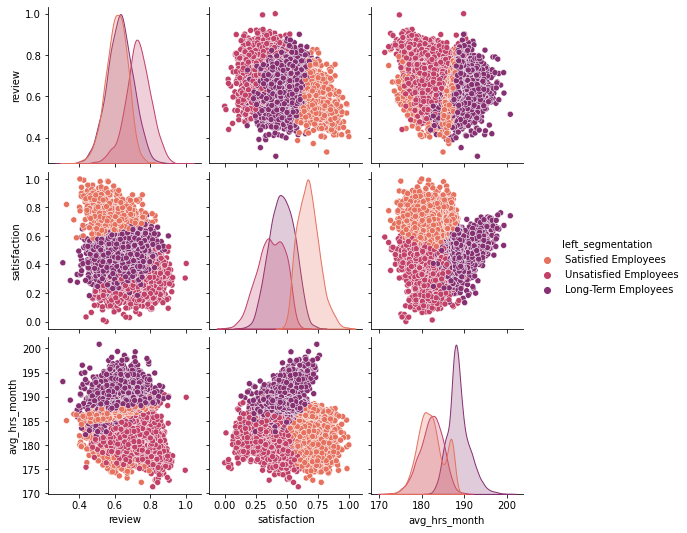

In [78]:
vars = [
 'review',
 'satisfaction',
 'avg_hrs_month',
 "left_segmentation"
]

# plot
sns.pairplot(data=df_cluster[vars], hue='left_segmentation', palette="flare")
plt.show()